In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240211%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240211T135708Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D58f3bd0fcf445af597f523ff364d3937566c37803e62c3c93c0aa12a86969a8fe72de6c33300f90fb912a08b59bc0bb0ce6e9a4267452bd5153c2614e3870af46c052367b5807d1942752aee88f4f42f92f928ae8821cf40bb109837ebe7586c95b92635495710c7672440737b0fdb4f32a3dd82f02dcb65a7a517b4bc6f0e35902abe6d87c09f516616cb2aa83e01ed4b656a29b076255eba618017097dfd28e9b06a1371ced4ebf46965951b47e84ee090d4ec51b154f5d2cf3d51a7bca9fcec224038c420db409dc16ce9d4f8b1fda18053a7aee223c6c9bb7a958bc5f140aea6ce97f139862cb84bee9e9f9da31d50281565fe333c56c8ded4d66ddea97f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
Data source import complete.


In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [3]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [4]:
paths[:5]


['/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_neat_ps.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_life_ps.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_hurl_ps.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_burn_ps.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_knock_ps.wav']

In [5]:
labels[:5]

['ps', 'ps', 'ps', 'ps', 'ps']

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,ps
1,/kaggle/input/toronto-emotional-speech-set-tes...,ps
2,/kaggle/input/toronto-emotional-speech-set-tes...,ps
3,/kaggle/input/toronto-emotional-speech-set-tes...,ps
4,/kaggle/input/toronto-emotional-speech-set-tes...,ps


In [7]:
df['label'].value_counts()

ps         800
neutral    800
fear       800
disgust    800
sad        800
angry      800
happy      800
Name: label, dtype: int64

In [8]:
def extract_mfcc(filename):
     y, sr = librosa.load(filename, duration=3, offset=0.5)
     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
     return mfcc

In [9]:
extract_mfcc(df['speech'][0])

array([-4.51180786e+02,  1.02048294e+02,  2.69270630e+01,  1.22117739e+01,
        1.72746944e+01, -8.62270737e+00, -4.74703074e+00,  3.06957936e+00,
       -2.37280350e+01, -1.30311069e+01, -1.90544224e+01, -1.30710583e+01,
       -6.85248804e+00, -2.14052558e+00, -1.17191696e+00, -5.47938943e-01,
       -8.34716702e+00,  6.20912600e+00,  8.62692535e-01,  3.34856415e+00,
        2.16456000e-02,  3.58268857e+00, -2.78831601e+00, -1.06497896e+00,
        3.03637624e-01,  2.84512806e+00, -7.25878620e+00,  3.70610499e+00,
       -4.54884005e+00,  3.24274254e+00, -3.99890447e+00, -3.41284943e+00,
       -9.44613338e-01, -8.38181555e-01,  5.22176456e+00,  1.33904715e+01,
        1.32900696e+01,  1.80151062e+01,  1.51833334e+01,  1.47473345e+01],
      dtype=float32)

In [10]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [11]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [12]:
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(5600, 7)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [15]:
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)


Epoch 1/50
70/70 [==============================] - 16s 188ms/step - loss: 0.8561 - accuracy: 0.6906 - val_loss: 0.8230 - val_accuracy: 0.7643
Epoch 2/50
70/70 [==============================] - 12s 174ms/step - loss: 0.2584 - accuracy: 0.9147 - val_loss: 0.2442 - val_accuracy: 0.9170
Epoch 3/50
70/70 [==============================] - 13s 183ms/step - loss: 0.1385 - accuracy: 0.9569 - val_loss: 0.3198 - val_accuracy: 0.8920
Epoch 4/50
70/70 [==============================] - 12s 177ms/step - loss: 0.1257 - accuracy: 0.9596 - val_loss: 0.2452 - val_accuracy: 0.9161
Epoch 5/50
70/70 [==============================] - 13s 185ms/step - loss: 0.0904 - accuracy: 0.9714 - val_loss: 0.2339 - val_accuracy: 0.9321
Epoch 6/50
70/70 [==============================] - 12s 175ms/step - loss: 0.1001 - accuracy: 0.9708 - val_loss: 0.1187 - val_accuracy: 0.9545
Epoch 7/50
70/70 [==============================] - 13s 183ms/step - loss: 0.0844 - accuracy: 0.9721 - val_loss: 0.0555 - val_accuracy: 0.9812

In [16]:
# Get the final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final accuracy percentage
print(f'Final Training Accuracy: {final_train_accuracy * 100:.2f}%')
print(f'Final Validation Accuracy: {final_val_accuracy * 100:.2f}%')


Final Training Accuracy: 100.00%
Final Validation Accuracy: 100.00%


In [28]:
# Load the audio file and extract MFCC features
audio_file_path = '/content/1001_IEO_DIS_MD.wav'
mfcc_features = extract_mfcc(audio_file_path)  # Use the extract_mfcc function you defined earlier

mfcc_features = np.expand_dims(mfcc_features, axis=0)  # Add batch dimension if necessary

predictions = model.predict(mfcc_features)

predicted_label_index = np.argmax(predictions)
predicted_label = enc.categories_[0][predicted_label_index]

print('Predicted label:', predicted_label)


1/1 [==============================] - 0s 222ms/step
Predicted label: disgust


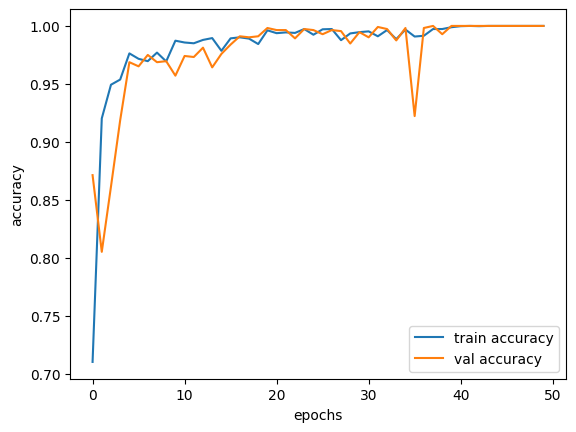

In [ ]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

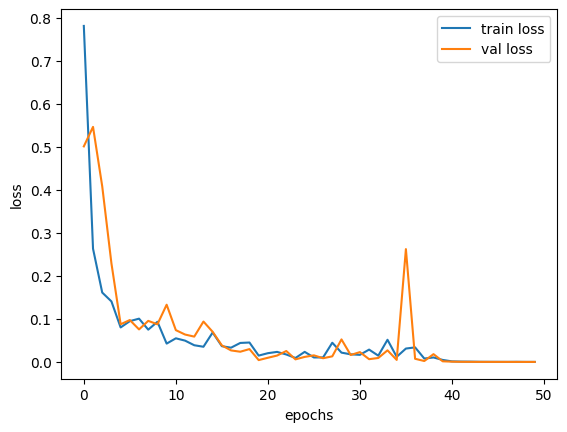

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()